# recurrent neural network (RNN)

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

2024-11-27 18:47:07.821576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 18:47:07.829323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 18:47:07.837899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 18:47:07.840347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 18:47:07.846922: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


## dataset

In [114]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)
# df4 = pd.read_csv('/home/yuan/results/epitope/shuffle.txt', sep='\t', header=None, index_col=None)

In [115]:
# drop duplicates
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
(3185991, 2) (3185991, 2)
(1863999, 2) (1863998, 2)


In [116]:
df2

,0,1
0,VGEERQMAEL,other
1,TTVSEYHWRK,other
2,LPTSLGNTMTCYIKA,other
3,RGVDVSVIPTAGDVV,other
4,VNTNGSWHINRTALN,other
...,...,...
3185986,GGGTKLTVLGQPKAAP,other
3185987,PSVSVSPGQTARITCS,other
3185988,GVQAEDEADYYCQAWD,other
3185989,GFNCYFPLQS,other


In [117]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(6915231, 2)


,0,1
435102,SRLWTKNSM,random
704950,PLSWGCAGFMMFTMYF,random
757674,DNKWCLDYNQKFEMK,random
1313875,IMITSCESDRRRVYE,epitope
797893,GALNVKESQE,other


In [118]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('random', 'SRLWTKNSM')
Counter({'other': 3185991, 'epitope': 1865242, 'random': 1863998})


In [119]:
# embedding
from my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

('random', 'TFYFENAISINRFRL')
4149138 1383046 1383047

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: NSVPVPRHW ['N', 'S', 'V', 'P', 'V', 'P', 'R', 'H', 'W']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 4047173), ('S', 3440695), ('A', 3407849), ('G', 3177949), ('E', 3158093), ('V', 3023399), ('P', 2815305), ('K', 2788853), ('T', 2689009), ('R', 2659450), ('D', 2549199), ('I', 2364991), ('Q', 2292851), ('N', 2109675), ('F', 2029133), ('Y', 1744423), ('H', 1558803), ('M', 1427269), ('C', 1396409), ('W', 1146320), ('X', 3119), ('U', 75), ('Z', 44), ('B', 33), ('J', 6)])
counts of input: [1911820, 1119103, 1118215]

## Step 3 encoding: encoding each unique token into integers...


In [125]:
from my_dataset import MyDataset
from my_collate import MyCollate
from my_rnn import MyRNN
from my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRNN(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRNN(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [145]:
num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8170 val_acc: 0.8136, val_recall: 0.7425
Epoch 1 acc: 0.8167 val_acc: 0.8139, val_recall: 0.7377
Epoch 2 acc: 0.8186 val_acc: 0.8141, val_recall: 0.7433
Epoch 3 acc: 0.8189 val_acc: 0.8142, val_recall: 0.7382
Epoch 4 acc: 0.8188 val_acc: 0.8142, val_recall: 0.7400
Epoch 5 acc: 0.8196 val_acc: 0.8150, val_recall: 0.7398
Epoch 6 acc: 0.8196 val_acc: 0.8153, val_recall: 0.7411
Epoch 7 acc: 0.8191 val_acc: 0.8145, val_recall: 0.7437
Epoch 8 acc: 0.8197 val_acc: 0.8143, val_recall: 0.7308
Epoch 9 acc: 0.8201 val_acc: 0.8146, val_recall: 0.7521


In [146]:
stat

,acc_train,loss_train,acc_valid,loss_valid,rec_valid
0,0.816983,0.388300,0.813626,0.393893,0.742540
1,0.816747,0.388529,0.813883,0.394338,0.737656
2,0.818552,0.386084,0.814146,0.393985,0.743320
3,0.818938,0.385223,0.814199,0.393196,0.738222
4,0.818830,0.385337,0.814171,0.393535,0.740006
5,0.819563,0.384246,0.814997,0.392800,0.739780
6,0.819583,0.384395,0.815266,0.392328,0.741118
7,0.819080,0.385219,0.814469,0.392843,0.743725
8,0.819705,0.384096,0.814276,0.393317,0.730823
9,0.820129,0.383519,0.814551,0.393545,0.752148


In [127]:
# test predict
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA'
]
res = p.predict(input)
res

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,6.067517e-01
1,AELMPVGDNN,1.031528e-01
2,AXAXAXAXA,6.788963e-08


In [128]:
print(trained_model.embedding)
print(trained_model.embedding.weight.shape)

Embedding(27, 48, padding_idx=0)
torch.Size([27, 48])


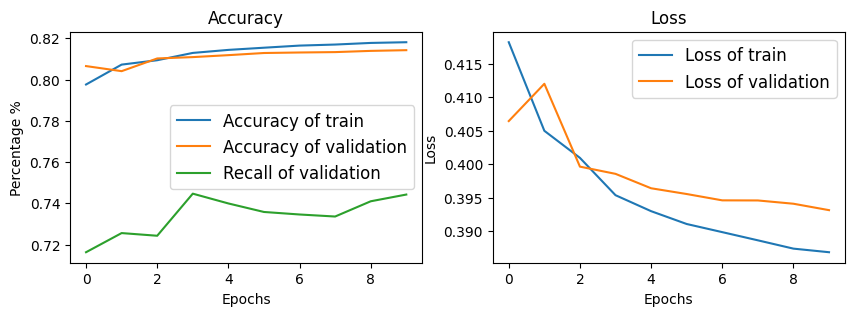

In [130]:
fig = plt.figure(figsize=(10,3))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Accuracy of train")
ax.plot(x_arr, stat.acc_valid, label="Accuracy of validation")
ax.plot(x_arr, stat.rec_valid, label="Recall of validation")
ax.legend(fontsize=12)
# ax.set_ylim(.8, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Loss of train")
ax.plot(x_arr, stat.loss_valid, label="Loss of validation")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [131]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7441317809743757,
 'accuracy': 0.8144922045310101,
 'loss': 0.3923020526516849}

In [132]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,SHSMRYFDTAVSR,0.739259,epitope
1,GIQYLRDY,0.287142,epitope
2,SRFCRGVPDA,0.061234,other
3,QEDAFFASQ,0.026200,other
4,AKTVSYDFRMWVSS,0.075150,random


372572 1010475


Text(0.5, 1.0, 'Distinguish non-epitopes, n = 1010475')

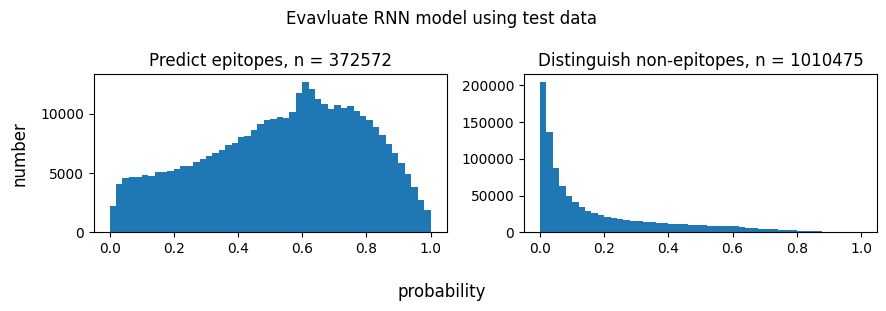

In [134]:
t = pred_test[pred_test['labels']=='epitope']['predict']
f = pred_test[~(pred_test['labels']=='epitope')]['predict']
print(len(t), len(f))

fig, ax = plt.subplots(1, 2, figsize=(9,3), layout='tight')
fig.suptitle('Evavluate RNN model using test data')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, bins=50)
ax[0].set_title(f'Predict epitopes, n = {len(t)}')
ax[1].hist(f, bins=50)
ax[1].set_title(f'Distinguish non-epitopes, n = {len(f)}')

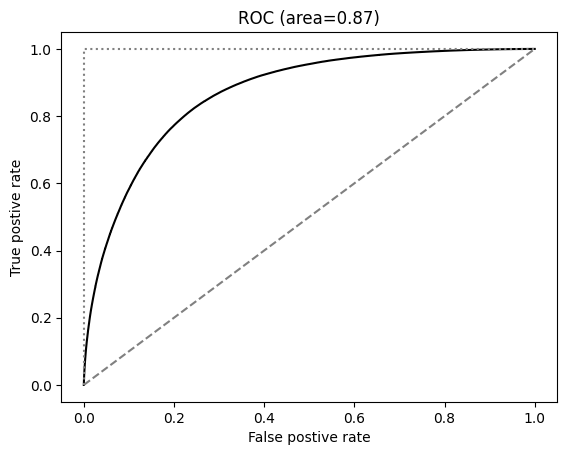

In [144]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(pred_test['labels'], pred_test['predict'], pos_label='epitope')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='black')
plt.title(f'ROC (area={roc_auc:.2f})')
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.plot([0,0,1],[0,1,1], linestyle=':', color='grey')

In [147]:
# save model
torch.save(input_vocab, '../models/epitopes_rnn_vocab.pth')
torch.save(model.state_dict(), '../models/epitopes_rnn_20.pth')